# Предсказание активности покупателей

Жуков Игорь, Москва, 2024 г.

# Описание задачи

- Имеется информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков. В них есть обезличенная история покупок клиентов за определенный период

**Задача:**
- Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

**Описание исходных данных**

- **apparel** (apparel.csv)

    - `client_id` - идентификатор клиента
    - `quantity` - количество купленных предметов
    - `price` - цена покупки
    - `date` - дата покупки
    - `message_id` - идентификатор покупки
    - `recommended_by` - идентификатор рекомендаций
    
    
  
- **marketplace** (marketplace.csv)
    - `client_id` - идентификатор клиента
    - `quantity` - количество купленных предметов
    - `price` - цена покупки
    - `date` - дата покупки
    - `message_id` - идентификатор покупки
    - `created_at` - дата создания записи
    
    
    
- **gifts** (gifts.csv)
   - `client_id` - идентификатор клиента
    - `quantity` - количество купленных предметов
    - `price` - цена покупки
    - `date` - дата покупки
    - `message_id` - идентификатор покупки
    - `recommended_by` - идентификатор рекомендаций

# План действий:

- загрузка данных
- первичный анализ данных
- обработка аномалий и пропусков
- создание единого датасета

- разделение выборки на обучающую и тестовую по хронологическому принципу - в тестовую записываются последние 30 дней выборки: будем использовать **статический метод**: выделим из датасета последние 30 дней, в котором нужно будет предсказать совершение покупки **всеми** покупателями из обучающей выборки, а предыдущий период будем использовать как обучающую выборку



- создание синтетических признаков и целевого признака в обучающей выборке

- изучение дисбаланса
- изучение распределения признаков в зависимости от значения целевого признака
- изучение корреляции
- изучение мультиколлинеарности


- построение пайплайна для линейной модели:
    - борьба с дисбалансом;
    - подбор гиперпараметров методом кросс-валидации.


- построение пайплайна для ансамблевой модели:
    - борьба с дисбалансом;
    - подбор гиперпараметров методом кросс-валидации.

    
- сравнение метрик моделей
- выбор модели
- изучение важности признаков для лучшей модели

- создание синтетических признаков и целевого признака в тестовой выборке


- тестирование качества прогнозирования лучшей модели на тестовой выборке
- проверка модели на адекватность на тестовой выборке
- подробный анализ метрик, в т.ч. матрицы ошибок, F-меры, безошибочности, точности и охвата


- отчет и рекомендации

## Загрузим необходимые библиотеки и осуществим настройки вывода

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pyarrow.feather as feather

import re
import os
#import keras
#import spacy
#import nltk
import phik
import joblib

from sklearn.preprocessing import (OneHotEncoder,
                                    LabelEncoder,
                                    OrdinalEncoder,
                                   StandardScaler,
                                   RobustScaler)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#from tensorflow.keras.layers import Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from sklearn.compose import (make_column_selector,
                             make_column_transformer,
                             ColumnTransformer)


from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                    TimeSeriesSplit)

from sklearn.metrics import (classification_report,
                             roc_auc_score,
                             f1_score,
                             accuracy_score,
                             roc_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

from imblearn.over_sampling import SMOTE, SMOTENC

from imblearn.pipeline import Pipeline, make_pipeline

### Настроим вывод данных на экран

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

### Определим значения констант

In [3]:
RANDOM_STATE = 53

## Загрузим и изучим данные

### Объявим функцию загрузки
с проверкой загрузки, заданием индекса и приведением наименований столбцов к общепринятому виду

In [4]:
def loader(path):
    
    '''Функция загружает файл по указанному пути и приводит заголовки к стандартному виду
Аргумент path должен принять путь к файлу, включая имя файла'''
    
    loaded_data=[]
    if os.path.exists(path):
        loaded_data = pd.read_csv(path)#, index_col=[0])
        print('Загружен файл: ', path)
        loaded_data.columns = [re.sub(r'(?<!^)(?=[A-Z])',
                '_', i).lower() for i in loaded_data.columns]
    else:
        print('Проверьте путь')

    return loaded_data

#### Загрузим данные

In [5]:
path1 = '/home/beerbear/Projects/Purchase_repeat_prediction/datasets/apparel-purchases.csv'
path2 = '/home/beerbear/Projects/Purchase_repeat_prediction/datasets/marketplace-purchases.csv'
path3 = '/home/beerbear/Projects/Purchase_repeat_prediction/datasets/gifts-purchases.csv'

In [6]:
apparel = loader(path1)
marketplace = loader(path2)
gifts = loader(path3)

Загружен файл:  /home/beerbear/Projects/Purchase_repeat_prediction/datasets/apparel-purchases.csv
Загружен файл:  /home/beerbear/Projects/Purchase_repeat_prediction/datasets/marketplace-purchases.csv
Загружен файл:  /home/beerbear/Projects/Purchase_repeat_prediction/datasets/gifts-purchases.csv


### Объявим функцию description для первичного исследования данных

In [7]:
def description(data):

    '''Функция принимает на входе датасет и выводит для исследуемого датасета:
    - описание info(),
    - первые две и последние две строки,
    - количество полных дубликатов,
    - количество пропущенных значений,
    - количество уникальных индексов,
    - статистические характеристики датасета,
    - первые 5 и последние 5 уникальных элементов каждого столбца
    '''
    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.head(2))
    display(data.tail(2))

    print('\n\033[1m Количество дубликатов: \033[0m', data.duplicated().sum())
    print('\033[1m Пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\033[1m Уникальных индексов: \033[0m', data.index.nunique())
    print('\n\033[1m  Статистические характеристики датасета: \033[0m')

    display(data.describe(include = 'all', datetime_is_numeric=True).T)

    print('\033[1m \nИзучим 5 минимальных и 5 максимальных значений каждого столбца: \033[0m \n')
    for column in data.columns:
        try:
            print(column, 'Уникальных значений:', data[column].nunique())
            print(sorted(data[data[column].notna()][column].unique())[0:5], '.....',
                  sorted(data[data[column].notna()][column].unique())[-5:-1],
                  sorted(data[data[column].notna()][column].unique())[-1], '\n')
        except:
            print('не может быть показана - пропуски или ошибка')


## Изучим имеющиеся данные

### Изучим датасет `apparel`

In [8]:
description(apparel)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


,client_id,quantity,price,date,message_id,recommended_by
133102,1515915625909375164,1,1699.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133103,1515915625909427129,1,1499.0,2022-12-31,1515915625638648227-9110-63ae8eb7dd104,bulk_message



 Количество дубликатов:  59250
 Пропущенных значений:  0
 Уникальных индексов:  133104

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,133104.0,NaN,NaN,NaN,1515915625598020096.0,142207773.48122,1515915625468060928.0,1515915625490427904.0,1515915625558532608.0,1515915625625638912.0,1515915625999034624.0
quantity,133104.0,NaN,NaN,NaN,1.004312,0.149315,1.0,1.0,1.0,1.0,30.0
price,133104.0,NaN,NaN,NaN,1110.433067,1257.080854,1.0,280.0,799.0,1499.0,63499.0
date,133104,366,2022-11-11,5270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message_id,133104,25426,1515915625489095763-6251-6311b13a4cf78,271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recommended_by,133104,1,bulk_message,133104,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

client_id Уникальных значений: 28891
[1515915625468061003, 1515915625468061170, 1515915625468061994, 1515915625468062158, 1515915625468062184] ..... [1515915625998152414, 1515915625998380048, 1515915625998392034, 1515915625998917545] 1515915625999034637 

quantity Уникальных значений: 12
[1, 2, 3, 4, 5] ..... [9, 15, 18, 20] 30 

price Уникальных значений: 3335
[1.0, 2.0, 3.0, 4.0, 5.0] ..... [48499.0, 52999.0, 53499.0, 60200.0] 63499.0 

date Уникальных значений: 366
['2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30'] ..... ['2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25'] 2023-10-26 

message_id Уникальных значений: 25426
['1515915625468061003-9148-63b54b04855a4', '1515915625468061170-11144-641ad2cda77a2', '1515915625468061170-11208-6423f082d2fcb', '1515915625468061170-13157-6483192913837', '1515915625468061994-7882-637397eab304e'] ..... ['1515915625997473009-13957-6529030d47567', '15159156

#### Выводы по результатам предварительного изучения данных датасета `apparel`, содержащего информацию о покупках  интернет-магазина одежды

- в датасете **133104** строк, **6** столбцов
- **пропущенные** данные **отсутствуют**
- **59250** полных **дубликатов**, **удалим** их

- столбец `client_id` - идентификатор клиента, всего **28891** уникальных клиентов
- столбец `quantity` - количество купленных единиц товара,  всего **12** уникальных значений от 1 до 30, более 75% выборки - это 1 купленный товар
- столбец `price` - цена покупки,  всего **3335** уникальных значений от 1 до 63499
- столбец `date` - дата покупки,  данные представлены за **366** дней с 26.10.2022 по 26.10.2023 включительно, самое большое число покупок (2579) было совершено 11.11.2022
- столбец `message_id` - вероятно идентификатор товара,  всего **25426** уникальных значений, самое частое встречается **271** раз, представляется бесполезным, удалим его
- столбец `recommended_by` - всего **1** уникальное значение: `bulk_message`, столбец **бесполезен**, **удалим** его

- столбец `date` имеет неверный тип `object`, для создания синтетических признаков нужно будет перевести его к типу `datetime`

#### Сразу проведем предварительную обрабоку: удалим полные дубликаты и ненужный столбец `recommended_by`, приведем столбец `date` к типу `datetime`

In [9]:
apparel = apparel.drop_duplicates().reset_index(drop = True)

In [10]:
apparel['date'] = pd.to_datetime(apparel['date'])

In [11]:
apparel = apparel.drop(['recommended_by'], axis = 1)

In [12]:
apparel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73854 entries, 0 to 73853
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   73854 non-null  int64         
 1   quantity    73854 non-null  int64         
 2   price       73854 non-null  float64       
 3   date        73854 non-null  datetime64[ns]
 4   message_id  73854 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [13]:
apparel.head()

,client_id,quantity,price,date,message_id
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
1,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56
2,1515915625468079941,1,999.0,2023-09-01,1515915625468079941-13718-64e899a67a51d
3,1515915625468079941,1,712.0,2023-09-01,1515915625468079941-13718-64e899a67a51d
4,1515915625468079941,1,1499.0,2023-09-01,1515915625468079941-13718-64e899a67a51d


- из датасета `apparel` **удалены** столбцы `recommended_by` и `message_id`
- из датасета `apparel` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

### Изучим датасет `marketplace`

In [14]:
description(marketplace)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13


,client_id,quantity,price,message_id,created_at,date
48180,1515915625575809442,1,15998.0,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:48:11
48181,1515915625575809442,1,15998.0,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:52:13



 Количество дубликатов:  2159
 Пропущенных значений:  0
 Уникальных индексов:  48182

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,48182.0,NaN,NaN,NaN,1515915625532520960.0,31733881.34617,1515915625440099840.0,1515915625517591808.0,1515915625531135232.0,1515915625557538816.0,1515915625588646144.0
quantity,48182.0,NaN,NaN,NaN,1.017413,0.540592,1.0,1.0,1.0,1.0,50.0
price,48182.0,NaN,NaN,NaN,27918.953157,44922.741767,0.0,1204.25,9998.0,35998.0,1299998.0
message_id,48182,20940,1515915625557752721-1909-64942a0b0e7f5,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,48182,365,2022-11-11,848,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,48182,31340,2023-01-30 22:35:46,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

client_id Уникальных значений: 17787
[1515915625440099873, 1515915625440939402, 1515915625440944408, 1515915625440947454, 1515915625440952940] ..... [1515915625588554419, 1515915625588559168, 1515915625588573679, 1515915625588627186] 1515915625588646092 

quantity Уникальных значений: 15
[1, 2, 3, 4, 5] ..... [20, 23, 27, 30] 50 

price Уникальных значений: 4991
[0.0, 1.0, 2.0, 3.0, 4.0] ..... [439996.0, 440996.0, 539998.0, 595798.0] 1299998.0 

message_id Уникальных значений: 20940
['1515915625440099873-1965-64abd07b9561d', '1515915625440099873-2021-64d219c458813', '1515915625440939402-1474-63d738fa8d5cc', '1515915625440944408-1587-63fef11f97d27', '1515915625440944408-1752-6450b79616277'] ..... ['1515915625588069308-2191-653784457880a', '1515915625588330419-2191-653784458a040', '1515915625588388293-2191-653784458f2c5', '1515915625588410504-2191-653784459183d'] 1515915625588455193-2189-6536452f38a47 

created_at Уника

#### Выводы по результатам предварительного изучения данных датасета `marketplace`, содержащего информацию о покупках маркетплейса

- в датасете **48182** строк, **6** столбцов
- **пропущенные** данные **отсутствуют**
- **2159** полных **дубликатов**, **удалим** их

- столбец `client_id` - идентификатор клиента, всего **17787** уникальных клиентов
- столбец `quantity` - количество купленных единиц товара,  всего **15** уникальных значений от 1 до 50, более 75% выборки - это 1 купленный товар
- столбец `price` - цена покупки,  всего **4991** уникальных значений от 1 до 1299998
- столбец `created_at` - дата покупки,  данные представлены за **365** дней с 26.10.2022 по 26.10.2023 включительно (1 какой-то день пропущен), самое большое число покупок (848) было совершено 11.11.2022
- столбец `message_id` - вероятно идентификатор товара,  всего **20940** уникальных значений, самое частое встречается **180** раз, представляется бесполезным, удалим его
- столбец `date` - **время** покупки

- столбцы `date` и `created_at` имеет неверный тип `object`, для сравнения и создания синтетических признаков нужно будет перевести их к типу `datetime`, сравнить и выбрать тот, в котором больше дней

#### Сразу проведем предварительную обрабоку: удалим полные дубликаты и ненужный столбец `message_id` приведем столбец `date` к типу `datetime`

In [15]:
marketplace = marketplace.drop_duplicates().reset_index(drop = True)

In [16]:
marketplace['date'] = pd.to_datetime(marketplace['date'], format = ('%Y-%m-%d')).dt.date
marketplace['date'] = pd.to_datetime(marketplace['date'], format = ('%Y-%m-%d'))

In [17]:
marketplace['created_at'] = pd.to_datetime(marketplace['created_at'], format = ('%Y-%m-%d'))

#### Сравним столбцы `date` и `created_at`

In [18]:
marketplace[marketplace['created_at'] != marketplace['date']].count().sum()

0

- столбцы `date` и `created_at` содержат одинаковые даты, столбец `created_at` **можно удалить**

In [19]:
marketplace = marketplace.drop(['created_at'], axis = 1)

In [20]:
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46023 entries, 0 to 46022
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   46023 non-null  int64         
 1   quantity    46023 non-null  int64         
 2   price       46023 non-null  float64       
 3   message_id  46023 non-null  object        
 4   date        46023 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.8+ MB


In [21]:
marketplace.head()

,client_id,quantity,price,message_id,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25


- из датасета `marketplace` **удалены** столбцы `created_at` и `message_id`
- из датасета `marketplace` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

### Изучим датасет `gifts`

In [22]:
description(gifts)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


,client_id,quantity,price,date,message_id,recommended_by
809,1515915625878133961,1,3442.0,2022-11-26,1515915625866862784-8170-6380c36047d7f,bulk_message
810,1515915625878133961,1,2695.0,2022-11-26,1515915625866862784-8170-6380c36047d7f,bulk_message



 Количество дубликатов:  56
 Пропущенных значений:  0
 Уникальных индексов:  811

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,811.0,NaN,NaN,NaN,1515915625875149312.0,62554070.509116,1515915625803180544.0,1515915625827804416.0,1515915625857734656.0,1515915625934780416.0,1515915626013602560.0
quantity,811.0,NaN,NaN,NaN,1.003699,0.060745,1.0,1.0,1.0,1.0,2.0
price,811.0,NaN,NaN,NaN,14468.795314,17774.341837,656.0,3878.0,7533.0,17938.0,173586.0
date,811,190,2023-05-22,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message_id,811,342,1515915625935652010-16166-6525589bca68f,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recommended_by,811,1,bulk_message,811,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

client_id Уникальных значений: 326
[1515915625803180506, 1515915625803180756, 1515915625803180771, 1515915625803180879, 1515915625803207150] ..... [1515915626005014483, 1515915626010039507, 1515915626011484905, 1515915626012131867] 1515915626013602677 

quantity Уникальных значений: 2
[1, 2] ..... [1] 2 

price Уникальных значений: 598
[656.0, 669.0, 749.0, 842.0, 989.0] ..... [86351.0, 99581.0, 101286.0, 110556.0] 173586.0 

date Уникальных значений: 190
['2022-10-26', '2022-10-28', '2022-11-02', '2022-11-03', '2022-11-04'] ..... ['2023-10-13', '2023-10-16', '2023-10-17', '2023-10-22'] 2023-10-24 

message_id Уникальных значений: 342
['1515915625803180756-10552-63ff5aa59192c', '1515915625803896872-14031-64ad5e7d5583a', '1515915625803905359-13219-64806078997a2', '1515915625805445981-11034-64147178a037e', '1515915625805526070-11466-6426e3a8f14e7'] ..... ['1515915625997770678-14492-64df77a78ece8', '1515915626002771410-1

#### Выводы по результатам предварительного изучения данных датасета `gifts`, содержащего информацию о покупках маркетплейса

- в датасете **811** строк, **6** столбцов
- **пропущенные** данные **отсутствуют**
- **56** полных **дубликатов**, **удалим** их

- столбец `client_id` - идентификатор клиента, всего **326** уникальных клиентов
- столбец `quantity` - количество купленных единиц товара,  всего **2** уникальных значений от 1 до 2, более 75% выборки - это 1 купленный товар
- столбец `price` - цена покупки,  всего **598** уникальных значений от 656 до 173586
- столбец `date` - дата покупки,  данные представлены за **190** дней с 26.10.2022 по 24.10.2023 включительно, самое большое число покупок (46) было совершено 22.05.2023
- столбец `message_id` - вероятно идентификатор товара,  всего **342** уникальных значения, самое частое встречается **22** раза, представляется бесполезным, удалим его
- столбец `recommended_by` - всего **1** уникальное значение: `bulk_message`, столбец **бесполезен**, **удалим** его

- столбец `date` имеет неверный тип `object`, для создания синтетических признаков нужно будет перевести его к типу `datetime`

#### Сразу проведем предварительную обрабоку: удалим полные дубликаты и ненужный столбец `message_id` приведем столбец `date` к типу `datetime`

In [23]:
gifts = gifts.drop_duplicates().reset_index(drop = True)

In [24]:
gifts['date'] = pd.to_datetime(gifts['date'], format = ('%Y-%m-%d')).dt.date
gifts['date'] = pd.to_datetime(gifts['date'], format = ('%Y-%m-%d'))

In [25]:
gifts = gifts.drop(['recommended_by'], axis = 1)

In [26]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   755 non-null    int64         
 1   quantity    755 non-null    int64         
 2   price       755 non-null    float64       
 3   date        755 non-null    datetime64[ns]
 4   message_id  755 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 29.6+ KB


In [27]:
gifts.head()

,client_id,quantity,price,date,message_id
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f


- из датасета `gifts` **удалены** столбцы `recommended_by` и `message_id`
- из датасета `gifts` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

## Создадим объединенный датасет `data`, на основе которого будут создаваться синтетические признаки, обучающая и тестовая выборки

In [28]:
data = pd.concat([apparel, marketplace, gifts],
                 ignore_index=True).sort_values(by = 'date',
                 ascending = True).reset_index(drop = True)
del [apparel, marketplace, gifts]

- из трех датасетов `apparel`, `marketplace`, `gifts` создан единый датасет `data`, который будет использован для создания **обучающей** и **тестовой** выборок, **синтетических** признаков и **целевого** признака

In [29]:
description(data)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120632 entries, 0 to 120631
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   120632 non-null  int64         
 1   quantity    120632 non-null  int64         
 2   price       120632 non-null  float64       
 3   date        120632 non-null  datetime64[ns]
 4   message_id  120632 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.6+ MB


,client_id,quantity,price,date,message_id
0,1515915625588327029,1,2499.0,2022-10-26,1515915625588327029-6834-63369b2cce369
1,1515915625500418210,1,1859.0,2022-10-26,1515915625500418210-7353-635652dce196d


,client_id,quantity,price,date,message_id
120630,1515915625983997819,1,2401.0,2023-10-26,1515915625557030662-13997-65377ad29408d
120631,1515915625559924944,1,1499.0,2023-10-26,1515915625559924944-14010-653a201ead981



 Количество дубликатов:  6741
 Пропущенных значений:  0
 Уникальных индексов:  120632

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
client_id,120632.0,NaN,NaN,NaN,1515915625576281344.0,1515915625440099840.0,1515915625500204800.0,1515915625544677120.0,1515915625581340672.0,1515915626013602560.0,122422257.184296
quantity,120632.0,NaN,NaN,NaN,1.011241,1.0,1.0,1.0,1.0,50.0,0.374303
price,120632.0,NaN,NaN,NaN,11776.348117,0.0,420.0,1399.0,4958.0,1299998.0,31152.69743
date,120632,NaN,NaN,NaN,2023-04-15 05:19:29.838849024,2022-10-26 00:00:00,2023-01-06 00:00:00,2023-04-21 00:00:00,2023-06-29 00:00:00,2023-10-26 00:00:00,NaN
message_id,120632,46708,1515915625489095763-6251-6311b13a4cf78,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

client_id Уникальных значений: 47004
[1515915625440099873, 1515915625440939402, 1515915625440944408, 1515915625440947454, 1515915625440952940] ..... [1515915626005014483, 1515915626010039507, 1515915626011484905, 1515915626012131867] 1515915626013602677 

quantity Уникальных значений: 17
[1, 2, 3, 4, 5] ..... [20, 23, 27, 30] 50 

price Уникальных значений: 7232
[0.0, 1.0, 2.0, 3.0, 4.0] ..... [439996.0, 440996.0, 539998.0, 595798.0] 1299998.0 

date Уникальных значений: 366
[numpy.datetime64('2022-10-26T00:00:00.000000000'), numpy.datetime64('2022-10-27T00:00:00.000000000'), numpy.datetime64('2022-10-28T00:00:00.000000000'), numpy.datetime64('2022-10-29T00:00:00.000000000'), numpy.datetime64('2022-10-30T00:00:00.000000000')] ..... [numpy.datetime64('2023-10-22T00:00:00.000000000'), numpy.datetime64('2023-10-23T00:00:00.000000000'), numpy.datetime64('2023-10-24T00:00:00.000000000'), numpy.datetime64('2023-10-25T00:00:

In [30]:
(data['quantity'] > 1).sum()

590

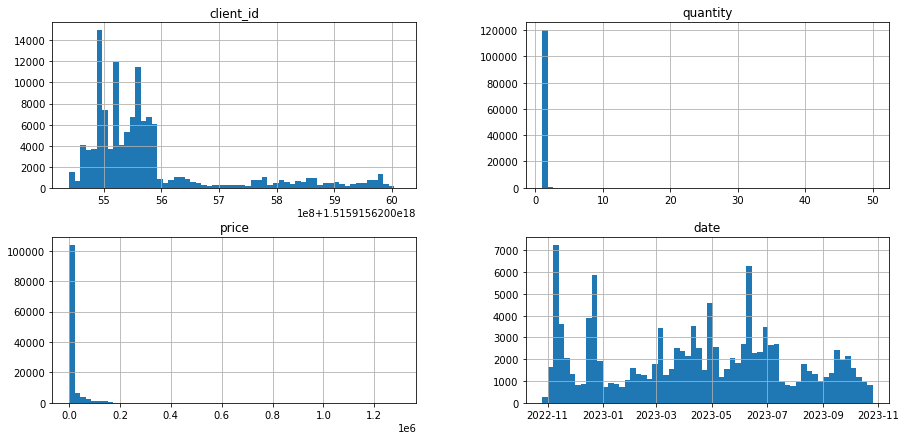

In [31]:
data.hist(figsize = (15, 7), bins = 60);

#### Выводы по результатам предварительного изучения данных сводного датасета `data`, содержащего информацию об объединенных покупках маркетплейса, магазина одежды и магазина подарков

- в датасете **120632** строк, **5** столбцов
- **пропущенные** данные **отсутствуют**
- **6741** полных **дубликатов**, но они пришли из трех разных датасетов, это **разные** покупки одного клиента в один день, **сохраним их**

- столбец `client_id` - идентификатор клиента, всего **47004** уникальных клиентов, заметно, что "старые" клиенты с меньшими номерами идентификаторов совершили больше покупок
- столбец `quantity` - количество купленных единиц товара,  всего **17** уникальных значений от 1 до 50, но за исключением **590** покупок - это всегда **1** купленный товар, столбец представляется **бесполезным**, предлагается **удалить**
- столбец `price` - цена покупки,  всего **7232** уникальных значений от **0** до **1 299 998**, 75% покупок имеют цену менее 5000 руб. - строки со значением 0 нужно **изучить подробнее**
- столбец `date` - дата покупки,  данные представлены за **366** дней с 26.10.2022 по 26.10.2023 включительно, на гистограмме хорошо заметны **пики** в *ноябре* (черная пятница), *декабре* (перед Новым годом), *марте* (к 8 марта), в *апреле и мае* (предположительно товары для дачи), в *июне* (предположительно летний отдых), *августе* (перед 1 сентября) и *октябре*
- столбец `message_id` - вероятно идентификатор товара,  всего **46708** уникальных значения, самое частое встречается **151** раз, был нужен для объединения датасетов и учета схожих покупок на разных площадках, представляется **бесполезным**, **удалим его**

- столбец `price` имеет тип данных `float64` но по виду данных похоже, что это `int64`, проверим и при необходимости **приведем** тип данных к `int64`

## Выделим из `data`  тестовую выборку размером в 30 дней и обучающую выборку за предыдущий период

#### Отсортируем датасет `data` по возрастанию даты

In [32]:
data = data.sort_values(by = ['date'], ascending = True)
data['date'].iloc[-1]

Timestamp('2023-10-26 00:00:00')

#### Выделим обучающую выборку

In [33]:
split_date = data['date'].iloc[-1] - pd.Timedelta(days=30)
data_train = data[data['date'] <= split_date]
data_train.tail(2)

,client_id,quantity,price,date,message_id
114035,1515915625586031028,1,23998.0,2023-09-26,1515915625586031028-2122-65125dd880b57
114041,1515915625468091813,1,174.0,2023-09-26,1515915625468091813-13864-651141a531bb2


#### Выделим тестовую выборку

In [34]:
data_test = data[data['date'] > split_date]
print('Количество полных дней в тестовой выборке',
      (data_test['date'].iloc[-1] - data_test['date'].iloc[0] + pd.Timedelta(days=1)).days)
display(data_test.head(2))
display(data_test.tail(2))


Количество полных дней в тестовой выборке 30


,client_id,quantity,price,date,message_id
114582,1515915625585733445,1,1742.0,2023-09-27,1515915625837520793-13868-6513cc3c45aba
114583,1515915625526260427,1,2.0,2023-09-27,1515915625526260427-2122-65125dca66962


,client_id,quantity,price,date,message_id
120587,1515915625580323762,1,1034.0,2023-10-26,1515915625491481128-13997-65377ac5f028a
120631,1515915625559924944,1,1499.0,2023-10-26,1515915625559924944-14010-653a201ead981


#### Удалим первоначальный датасет для экономии памяти

In [35]:
del data

## Осуществим предобработку датасета `data_train`

### Объявим фунцию `prep`, которая примет на вход датасет и выполнит следующие действия:
- удалит ненужные столбцы
- удалит нулевые значения из столбца `price`
- cуммирует по каждому клиенту все покупки за 1 день
- вернет датасет, содержащий суммарные покупки каждого клиента за 1 день

In [36]:
def prep(data):
    '''Функция принимает на вход датасет и выполняет следующие действия:
- удаляет ненужные столбцы, оставляет только ['client_id', 'date', 'price']
- удаляет нулевые значения из столбца `price`
- cуммирует по каждому клиенту все покупки за 1 день

Функция возвращает датасет, содержащий суммарные покупки каждого клиента за 1 день
    '''
    # Оставим в датасете только нужные для моделирования столбцы
    data = data[['client_id', 'date', 'price']]
    
    # Удалим строки с нулевым значением цены
    data = data[data['price'] != 0]
    
    # Создадим датафрейм `data` в который запишем объединенные по датам покупки каждого клиента,
    # цену всех покупок клиента за день суммируем
    
    data = pd.pivot_table(data, index = ['date', 'client_id'],
                          values = 'price', aggfunc = 'sum').reset_index(drop = False)

    return data

### Проверим работу функции и обработаем датасет `data_train`

In [37]:
grouped_data = prep(data_train)
grouped_data.head(3)

,date,client_id,price
0,2022-10-26,1515915625468222486,3999.0
1,2022-10-26,1515915625489888679,2206.0
2,2022-10-26,1515915625500418210,1859.0


#### Проверим сумму всех покупок самого часто покупающего клиента в сгруппированном датасете и в изначальном

In [38]:
data_train['client_id'].value_counts(ascending = False).head(2)

1515915625546393273    238
1515915625557752721    217
Name: client_id, dtype: int64

In [39]:
data_train[data_train['client_id'] == 1515915625526260427]['price'].sum() == \
grouped_data[grouped_data['client_id'] == 1515915625526260427]['price'].sum()

True

#### Проверим сумму всех покупок в сгруппированном датасете и в изначальном

In [40]:
data_train['price'].sum() == grouped_data['price'].sum()

True

#### Проверим сумму покупок самого часто покупающего клиента за один день в сгруппированном датасете и в изначальном

In [41]:
data_train[(data_train['client_id'] == 1515915625526260427) &
     (data_train['date'] == pd.to_datetime('2022-11-06'))]['price'].sum()

16009.0

In [42]:
grouped_data[(grouped_data['client_id'] == 1515915625526260427) &
     (grouped_data['date'] == pd.to_datetime('2022-11-06'))]['price'].sum()

16009.0

#### Присвоим изначальному датасету `data_train` значение датасета `grouped_data`

In [43]:
data_train = grouped_data
del grouped_data
data_train.head(3)

,date,client_id,price
0,2022-10-26,1515915625468222486,3999.0
1,2022-10-26,1515915625489888679,2206.0
2,2022-10-26,1515915625500418210,1859.0


- в датасете `data_train` произведено объединение всех покупок каждого клиента за один день с указанием суммарной стоимости

## Создадим `синтетические` признаки

#### Порядок создания признаков и целевого признака таков:
- отрежем от выборки последние 30 дней для создания тестовой выборки, оставшееся - обучающая выборка
---
- посчитаем по всем клиентам обучающей выборки разницу в днях между покупками
- по всем покупкам, срок до предыдущей у которых не более 30 дней, проставим значение целевого признака = 1
- по всем остальным покупкам проставим значение целевого признака = 0
- сделаем базу уникальных клиентов на обучающей выборке
- посчитаем для каждого клиента его характеристики (количество покупок, среднее время между покупками и средний чек)
- присоединим характеристики клиентов из справочника к обучающей выборке
---

- всем строкам в тестовой выборке присвоим значение target = 1, потому что это была покупка
- подсоединим к тестовой выборке характеристики клиентов из созданного на обучающей выборке справочника клиентов с присоединением `right`, чтобы удалить клиентов, совершивших покупку в последний месяц, но отсутствующих в справочнике, так как у нас нет данных для прогнозирования по ним, и добавить всех клиентов, которые есть в справочнике
- всем клиентам в тестовой выборке, у которых целевой признак не равен 1, проставим значение 0, так как они не совершили покупку в последний месяц

### Объявим класс, который создаст набор признаков для обучения и вектор целевого признака для обучающей выборки, а также набор признаков для тестирования и вектор целевого признака для тестовой выборки

In [44]:
class features_target_maker(object):
    
    '''
    Класс `features_target_maker` принимает на вход обучающую выборку
    data_train и возвращает набор признаков и вектор 
    целевого признака для обучающей выборки при вызове метода .fit_transform
    
    При вызове метода .fit и .fit_transform на основе обучающей выборки создаются 
    агрегированные признаки 'days_to_previous_mean', 'price_count', 'price_mean',
    которые при вызове метода .transform передаются в набор признаков
    валидационной выборки, чтобы избежать утечки целевого признака
    в результате использования агрегированных данных
    
    Также при вызове методов fit_transform и .transform создается целевой признак
    
    Обученный на обучающей выборке класс принимает на вход валидационную выборку и возвращает 
    набор признаков и вектор целевого признака для валидационной выборки
        
    '''
    
    def __init__(self, *args):
        self.args = args
        self.data_train = None
        self.clients = None
        
    
    def fit(self, data_train, target_train= None):
        self.data_train = data_train
                
       # Посчитаем по каждому клиенту срок между повторной покупкой и первоначальной,
       # результат запишем к повторной покупке
        self.data_train = self.data_train.sort_values(by = ['client_id',
                                                            'date'], ascending = True)
        
        self.data_train['days_to_previous'] = self.data_train.groupby(
                                         by = 'client_id')['date'].diff().dt.days
        
        self.data_train = self.data_train.sort_values(
                                         by = ['date'], ascending = True)
        
        # Введем столбец с целевым признаком - если клиент совершил повторную покупку 
        # через 30 или менее дней, значение целевого признака = `1`
        
        self.data_train.loc[:, 'target'] = 0
        self.data_train.loc[self.data_train['days_to_previous'] <=30, 'target'] = 1
        
        
        # Создадим справочник клиентов на обучающей выборке
        # Посчитаем по каждому клиенту его покупательские характеристики: количество 
        # покупок за известный период, минимальный, максимальный, средний и медианный сроки между покупками
        
        self.clients = pd.pivot_table(self.data_train, index = 'client_id',
                                      values = ('price', 'days_to_previous'),
                            aggfunc = ('count', 'mean', 'median', 'min', 'max'))
        
        clients_columns = []
        for item in self.clients.columns:
            item = item[0]+'_'+item[1]
            clients_columns.append(item)
        self.clients.columns = clients_columns
        
        # Заполним пропуски в базе клиентов значением (999) - бесконечно большой срок
        
        self.clients = self.clients.fillna(999)
        
         # Удалим столбцы ['days_to_previous', 'price'], как несущие утечку целевого признка 
        self.data_train = self.data_train.drop(['days_to_previous', 'price'], axis = 1)
        

        return self
    
    
    ###########################################################################
    
    
    def fit_transform(self, data_train, target_train= None):
        
        self.data_train = data_train
                
       # Посчитаем по каждому клиенту срок между повторной покупкой и первоначальной,
       # результат запишем к повторной покупке
        self.data_train = self.data_train.sort_values(by = ['client_id',
                                                  'date'], ascending = True)
        
        self.data_train['days_to_previous'] = self.data_train.groupby(
                                         by = 'client_id')['date'].diff().dt.days
        
        self.data_train = self.data_train.sort_values(
                                         by = ['date'], ascending = True)
        
        # Введем столбец с целевым признаком - если клиент совершил повторную покупку 
        # через 30 или менее дней, значение целевого признака = `1`
        
        self.data_train.loc[:, 'target'] = 0
        self.data_train.loc[self.data_train['days_to_previous'] <=30, 'target'] = 1
        
        
        # Создадим справочник клиентов на обучающей выборке
        # Посчитаем по каждому клиенту его покупательские характеристики: количество 
        # покупок за известный период, минимальный, максимальный, средний и медианный сроки между покупками
        
        self.clients = pd.pivot_table(self.data_train, index = 'client_id',
                                      values = ('price', 'days_to_previous'),
                            aggfunc = ('count', 'mean')) #, 'median', 'min', 'max'))
        
        clients_columns = []
        for item in self.clients.columns:
            item = item[0]+'_'+item[1]
            clients_columns.append(item)
        self.clients.columns = clients_columns
        
        # Заполним пропуски в базе клиентов значением (999) - бесконечно большой срок
        
        self.clients = self.clients.fillna(999)
        
        # Подсоединим к обучающей выборке характеристики клиентов
        self.data_train = self.data_train.join(self.clients, how = 'left',
                                               on='client_id').reset_index(drop = True)
        
         # Удалим столбцы ['days_to_previous', 'price'], как несущие утечку целевого признка 
        self.data_train = self.data_train.drop(['days_to_previous', 'price'], axis = 1)
       
        
        important_features = ['days_to_previous_mean', 'price_count', 'price_mean']
        
        target_train = self.data_train['target'] 
        data_train = self.data_train[important_features]
        
        
        return data_train, target_train

    ###########################################################################

        
    
    def transform(self, data_test, target_test = None):
        
        data_test.loc[:, 'target'] = 1
        
        data_test = data_test.join(self.clients, how = 'right', on='client_id').reset_index(drop = True)
        data_test['target'] = data_test['target'].fillna(0).astype('int8')
        data_test['date'] = data_test['date'].fillna(data_test['date'].median())
                                      
        important_features = ['days_to_previous_mean', 'price_count', 'price_mean']
                                      
        target_test = data_test['target'] 
        data_test = data_test[important_features]
        
        return data_test, target_test

## Подготовим данные для машинного обучения

---

### Создадим массив признаков и вектор целевого признака `обучающей` выборки

In [45]:
feature_maker = features_target_maker()

In [46]:
feature_maker.fit(data_train)

In [47]:
features_train, target_train = feature_maker.fit_transform(data_train)

In [48]:
display(features_train.head(2))
print('Размерность массива признаков', features_train.shape)
print('Доля положительного класса целевого признака', round(target_train.mean(), 2))

,days_to_previous_mean,price_count,price_mean
0,999.0,1,17998.0
1,999.0,1,1859.0


Размерность массива признаков (54256, 3)
Доля положительного класса целевого признака 0.1


- из датасета `data_train` создан **массив признаков** обучающей выборки, имеющий три признака: 
    - средняя дата до предыдущей покупки `days_to_previous_mean`
    - средняя цена всех покупок `price_mean`
    - количество покупок `price_count`
    
    и вектор **целевого** признака `target` 
- размер **обучающей** выборки **54 256** объектов

Использование **других признаков**, таких как минимальная и максимальная длительность периода между покупками, медианные значения цены покупки и длительности между покупками, максимальная и минимальная цена покупки **не дали улучшения** качества модели

## Проведем исследовательский анализ признаков

### Объявим функцию для определения категориальных и количественных признаков

In [49]:
def interval_categorical(data, threshold = 10):
    '''
    Функция принимает на входе датасет `data` и порог `threshold` отнесения к категориальным признакам, 
    и возвращает перечни столбцов датасета, содержащие количественные и категориальные признаки.
    
    Значение порога `threshold` по умолчанию равно 10
    '''
    
    
    interval_cols = []
    categorical_cols = []

    for column in data.columns:
        if data[column].nunique() > threshold:
            interval_cols.append(column)
        else:
            categorical_cols.append(column)

    print('\ninterval_cols\n', sorted(interval_cols))
    print('\ncategorical_cols\n', sorted(categorical_cols))

    return interval_cols, categorical_cols

### Проверим дисбаланс классов

Количество значений каждого класса в выборке:

0    48818
1     5438
Name: target, dtype: int64
0    0.9
1    0.1
Name: target, dtype: float64


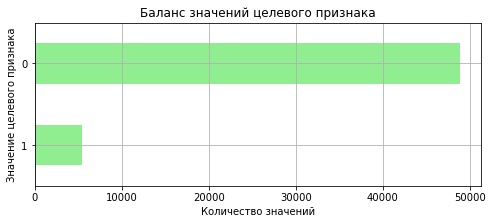

In [50]:
print('Количество значений каждого класса в выборке:\n')
print(target_train.value_counts())
print(round(target_train.value_counts()/target_train.count(),2))

target_train.value_counts(ascending = True).plot(
                              kind = 'barh',
                              grid = True,
                              color = 'lightgreen',
                              figsize = (8, 3));
plt.title('Баланс значений целевого признака');
plt.xlabel('Количество значений');
plt.ylabel('Значение целевого признака');

- имеется **сильный** дисбаланс классов: у **целевого** признака **90%** выборки имеет **нулевой** класс, и всего **10%** положительных значений, что необходимо учесть при обучении моделей

### Изучим распределение количественных признаков в зависимости от значения целевого признака

#### Создадим из массива признаков и вектора целевого признака специальный массив признаков `features_and_target` для изучения

In [51]:
features_and_target = features_train.copy(deep = True)
features_and_target.loc[:, 'target'] = target_train
features_and_target.tail(3)

,days_to_previous_mean,price_count,price_mean,target
54253,999.000000,1,598.0,0
54254,20.666667,4,33567.0,1
54255,79.500000,5,14717.6,1


In [52]:
interval_cols, categorical_cols = interval_categorical(features_and_target)


interval_cols
 ['days_to_previous_mean', 'price_count', 'price_mean']

categorical_cols
 ['target']


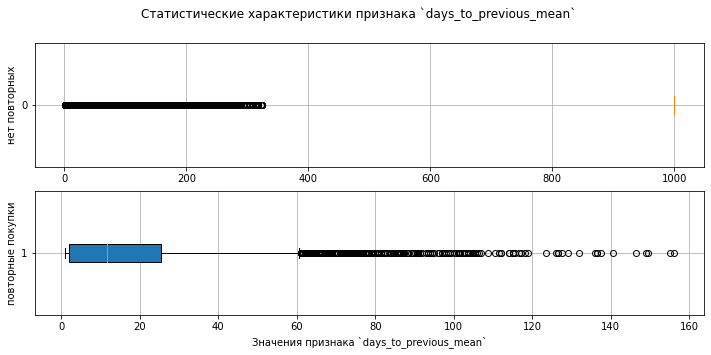

,count,mean,std,min,25%,50%,75%,max
нет повторных,48818.0,805.074998,379.162033,1.0,999.0,999.0,999.0,999.0
повторные покупки,5438.0,19.206824,22.579696,1.0,2.0,11.8,25.5,156.0


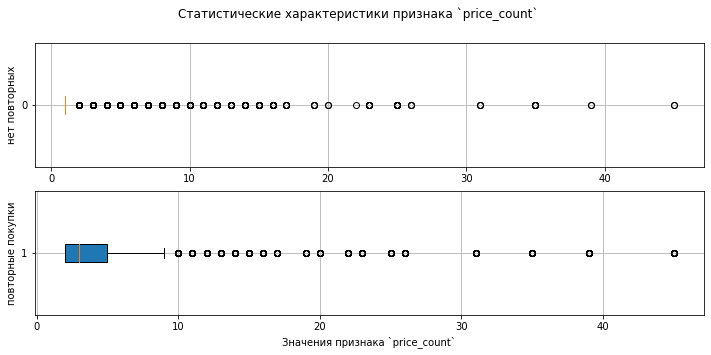

,count,mean,std,min,25%,50%,75%,max
нет повторных,48818.0,1.395633,1.311078,1.0,1.0,1.0,1.0,45.0
повторные покупки,5438.0,5.469290,6.998730,2.0,2.0,3.0,5.0,45.0


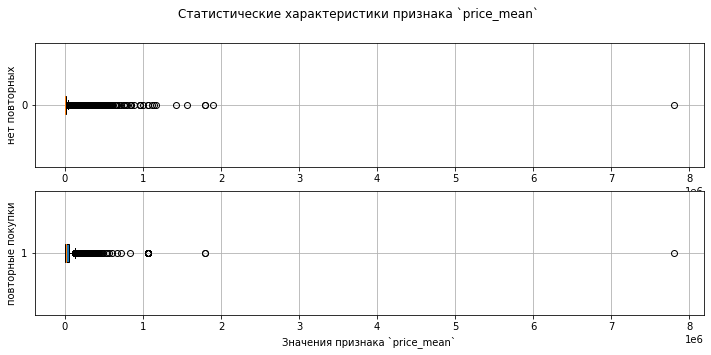

,count,mean,std,min,25%,50%,75%,max
нет повторных,48818.0,22103.654279,65481.984343,1.0,1324.500000,2998.000000,14100.875,7799988.0
повторные покупки,5438.0,41653.093672,133977.225747,1.0,2238.666667,12631.666667,50727.850,7799988.0


In [53]:
for feature in interval_cols:
    print('\n')
    fig, ax = plt.subplots(2, 1, figsize = (12, 5));
    plt.suptitle("Статистические характеристики \
признака `" + feature + "`");

    box_0 = features_and_target[features_and_target['target'] == 0][[feature]]
    ax[0].boxplot(box_0, vert = False,
                  patch_artist = True,
                  labels = '0');

    ax[0].grid(True);
    ax[0].set_ylabel('нет повторных');


    box_1 = features_and_target[features_and_target['target'] == 1][[feature]]
    ax[1].boxplot(box_1, vert = False,
                 patch_artist = True,
                 labels = '1');
    ax[1].grid(True)
    ax[1].set_ylabel('повторные покупки')


    plt.xlabel('Значения признака `' + feature + '`');
    plt.show();
    feature_descript = pd.DataFrame(box_0.describe())
    feature_descript['1'] = box_1.describe()

    feature_descript.columns = ['нет повторных', 'повторные покупки']
    display(feature_descript.T)

- **Анализ распределения количественных признаков в зависимости от значения целевого признака показывает следующее:**

   - более 75% клиентов, не имеющих повторных покупок в течение 30 дней, имеют бесконечно большой средний срок до предыдущей покупки (означает, что предыдущей покупки не было в обозримом периоде)
   - 75% клиентов, у которых были повторные покупки в течение 30 дней, имеют средний срок до предыдущей покупки не более 25.5 дней
   
   - 75% клиентов, не имеющих повторных покупок, имеют общее количество покупок не более 1
   - все клиенты, имеющие повторные покупки, имеют общее количество покупок более 1
   
   - 75% клиентов, не имеющих повторных покупок, имеют средний чек менее 14100 рублей, и половина - менее 3000
   - 50% клиентов, имеющих повторные покупки, имеют средний чек более 12600 рублей
   
- Таким образом, **портрет клиента**, который с большой вероятностью совершит повторную покупку в течение 30 дней:
    - средний срок до предыдущей покупки менее 25 дней
    - имеет более 1 покупки
    - имеет средний чек более 12600 рублей

### Изучим корреляцию признаков с целевым признаком и мультиколлинеарность

In [54]:
corr_matrix = features_and_target.phik_matrix(
    interval_cols = interval_cols)
corr_matrix['target'].sort_values(ascending = False)

target                   1.000000
price_count              0.482581
days_to_previous_mean    0.479344
price_mean               0.039542
Name: target, dtype: float64

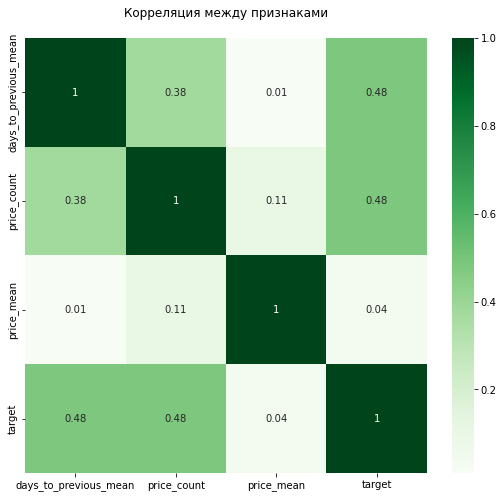

In [55]:
plt.figure(figsize = (9, 8))
plt.title('Корреляция между признаками\n');
sns.heatmap(round(abs(corr_matrix), 2),
            annot = True,
            cmap = 'Greens');
plt.show()

- имеется **средняя** корреляция целевого признака с `price_count` и `days_to_previous_mean`
- корреляция с признаком средней цены `price_mean` **отсутствует**
- **мультиколлинеарность** между признаками слабая

- полученные признаки хорошо подходят для обучения модели и прогнозирования клиентов, которые совершат покупку в течение 30 дней

## Обучим и протестируем модели методом кросс-валидации

### Обучим и протестируем модель `SGDClassifier` методом `кросс-валидации`

#### Зададим неизменяемые гиперпараметры модели

In [56]:
sgd = SGDClassifier(
    random_state = RANDOM_STATE,
    #loss='hinge',
    #penalty='l2',
    alpha=0.0001,
    #l1_ratio=0.15, 
    fit_intercept=True,
    max_iter=1000, 
    tol=0.001, 
    shuffle=True, 
    verbose=0, 
    epsilon=0.1, 
    n_jobs=-1,
    #learning_rate='optimal',
    eta0=0.0, 
    power_t=0.5,
    early_stopping=True, 
    validation_fraction=0.1,
    n_iter_no_change=5, 
    class_weight='balanced',
    warm_start=True,
    average=False
    )

#### Определим функцию, выравнивающую масштаб признаков

In [57]:
scaler = StandardScaler()

#### Определим балансировщик классов

In [58]:
balancer = SMOTE(random_state=RANDOM_STATE)

#### Сконструируем конвейер для предобработки данных и обучения модели

In [59]:
sgd_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("balancer", balancer),
    ("sgd", sgd)])
print(sgd_pipe)

Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', SMOTE(random_state=53)),
                ('sgd',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               n_jobs=-1, random_state=53, warm_start=True))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `AUC-ROC` методом `кросс-валидации`

In [60]:
sgd_param_grid = {
"sgd__loss": ['log_loss'], #['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 
               # 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
"sgd__penalty": ['elasticnet'], #['l2', 'l1', 'elasticnet'],
"sgd__learning_rate": ['optimal'], #'constant', 'adaptive', 'invscaling'],
"sgd__l1_ratio" : [0.06] #, 0.07, 0.08, 0.09, 0.05]
}

#### Объявим функцию поиска оптимальных гиперпараметров

In [61]:
sgd_search = GridSearchCV(
    sgd_pipe,
    sgd_param_grid,
    scoring = 'roc_auc',
    cv = TimeSeriesSplit(n_splits=10),
    verbose = 1
)

#### Проведем поиск оптимальных гиперпараметров

In [62]:
sgd_search.fit(features_train, target_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('balancer', SMOTE(random_state=53)),
                                       ('sgd',
                                        SGDClassifier(class_weight='balanced',
                                                      early_stopping=True,
                                                      n_jobs=-1,
                                                      random_state=53,
                                                      warm_start=True))]),
             param_grid={'sgd__l1_ratio': [0.06],
                         'sgd__learning_rate': ['optimal'],
                         'sgd__loss': ['log_loss'],
                         'sgd__penalty': ['elasticnet']},
             scoring='roc_auc', verbose=1)

In [63]:
print("\nЛучшее полученное методом кросс-валидации \n \
значение метрики AUC_ROC = %0.4f:" % sgd_search.best_score_,
"найдено при следующих параметрах")
print(sgd_search.best_params_)


Лучшее полученное методом кросс-валидации 
 значение метрики AUC_ROC = 0.9597: найдено при следующих параметрах
{'sgd__l1_ratio': 0.06, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log_loss', 'sgd__penalty': 'elasticnet'}


#### Выводы по результатам обучения и тестирования модели `SGDClassifier`

- лучшее полученное методом кросс-валидации значение метрики **AUC_ROC = 0.9597**

### Обучим модель `CatBoost`

In [64]:
interval_cols, categorical_cols = interval_categorical(features_train)


interval_cols
 ['days_to_previous_mean', 'price_count', 'price_mean']

categorical_cols
 []


#### Зададим неизменяемые гиперпараметры модели

In [65]:
cb = CatBoostClassifier(
    random_seed = RANDOM_STATE,
    cat_features = categorical_cols,
    auto_class_weights = 'Balanced',
    verbose=False)

#### Зададим функцию, балансирующую классы

In [66]:
balancer = SMOTE(random_state=RANDOM_STATE)

#### Сконструируем конвейер для балансировки данных и обучения модели

In [67]:
cb_pipe = Pipeline(steps=[
    #("encoder", encoder),
    #("balancer", balancer), - собственный балансировщик Catboost дает результат лучше
    #("encoder", encoder),
    ("cb", cb)])
print(cb_pipe)

Pipeline(steps=[('cb',
                 <catboost.core.CatBoostClassifier object at 0x7ff1a48c5630>)])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `AUC-ROC` методом `кросс-валидации`

In [68]:
cb_param_grid = {

    #'cb__learning_rate': [0.1], #0.5, 0.3, 0.2, 0.4, 0.6, 0.7, 0.8], #, 0.11, 0.12],
    #[0.5, 0.3, 0.2, 0.4, 0.6, 0.7, 0.8, 0.1],
   'cb__iterations': [9], #[6, 7, 8, 9, 10, 15, 20], # [9]
         # ],

    'cb__depth': [6] #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #[6]
}

#### Объявим функцию `GridSearchCV` для поиска оптимальных гиперпараметров

In [69]:
cb_search = GridSearchCV(
                 cb_pipe,
                 cb_param_grid,
                 cv = TimeSeriesSplit(n_splits=10),
                 scoring = 'roc_auc',
                 verbose = 1)

#### Проведем поиск оптимальных гиперпараметров

In [70]:
cb_search.fit(features_train, target_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('cb',
                                        <catboost.core.CatBoostClassifier object at 0x7ff1a48c5630>)]),
             param_grid={'cb__depth': [6], 'cb__iterations': [9]},
             scoring='roc_auc', verbose=1)

In [71]:
print("\nЛучшее полученное методом кросс-валидации \n\
значение метрики ROC-AUC = %0.4f:" % cb_search.best_score_,
"найдено при следующих гиперпараметрах")
print(cb_search.best_params_)


Лучшее полученное методом кросс-валидации 
значение метрики ROC-AUC = 0.9617: найдено при следующих гиперпараметрах
{'cb__depth': 6, 'cb__iterations': 9}


#### Выводы по результатам обучения и тестирования модели `CatBoostClassifier`

- в результате подбора гиперпараметров, обучения и кросс-валидации модели `CatBoostClassifier` было получено значение метрики **AUC_ROC = 0.9617**, что превосходит метрику модели `SGDClassifier` (**0.9597**)
- модель `CatBoostClassifier` с гиперпараметрами:
    - `depth`: 6
    - `iterations`: 9
    - `auto_class_weights` = 'Balanced',


    может быть **рекомендована** для дальнейшего тестирования

### Изучим важность признаков для лучшей модели

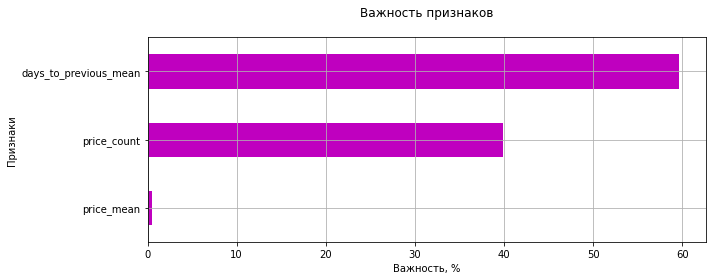

days_to_previous_mean    59.623924
price_count              39.859450
price_mean                0.516625
dtype: float64


In [72]:
cb_imp = pd.Series(
    cb_search.best_estimator_[-1].get_feature_importance(),
    index = features_train.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(10, 4))
cb_imp.plot.barh(ax=ax, color = 'm')
ax.set_title("Важность признаков\n")
ax.set_xlabel('Важность, %')
ax.set_ylabel('Признаки')
fig.tight_layout()
ax.grid(True)
plt.show()
print(cb_imp.sort_values(ascending = False))

- анализ важности признаков демонстрирует, что **наиболее значимый** признак - это признак среднего срока до предыдущей покупки `days_to_previous_mean`, на **втором** месте идет признак частоты покупок `price_count`, на третьем, с очень малым весом - средний чек покупателя `price_mean`

## Протестируем модель `CatBoostClassifier`

### Создадим массив признаков и вектор целевого признака `тестовой` выборки

In [73]:
data_test = prep(data_test)

In [74]:
features_test, target_test = feature_maker.transform(data_test)
display(features_test.tail(2))
print('Размерность массива признаков', features_test.shape)
print('Доля положительного класса целевого признака', round(target_test.mean(), 2))

,days_to_previous_mean,price_count,price_mean
44859,999.0,1,7534.0
44860,999.0,1,25834.0


Размерность массива признаков (44861, 3)
Доля положительного класса целевого признака 0.02


- из датасета `data_test` созданы **массив признаков** имеющий три признака: 
    - средняя дата до предыдущей покупки
    - средняя цена всех покупок
    - количество покупок
    
- и вектор **целевого** признака `target_test`

- размер **тестовой** выборки **44861** объекта и **3** признака

### Проверим значение метрики `AUC-ROC` на тестовой выборке

#### Обучим модель на тестовой выборке и получим вектор `предсказаний` и вектор `вероятностей предсказаний положительного класса`

In [75]:
%%time
cb_search.best_estimator_.fit(
    features_train, target_train)

cb_predictions_test = cb_search.best_estimator_.predict(
    features_test)

cb_proba_one_test = cb_search.best_estimator_.predict_proba(
    features_test)[:, 1]

print('Вектор предсказаний:', cb_predictions_test)

Вектор предсказаний: [1 0 1 ... 0 0 0]
CPU times: user 264 ms, sys: 31.3 ms, total: 295 ms
Wall time: 77.4 ms


- время **обучения и предсказания** модели составляет менее секунды, модель **подходит** для прогнозирования в **реальном времени**

#### Изучим диаграмму рабочей характеристики модели `ROC`

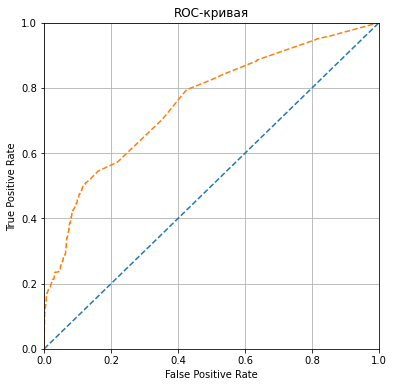


Значение метрики ROC-AUC на обучающей выборке = 0.9617:

Значение метрики ROC-AUC на тестовой выборке = 0.7527:


In [76]:
fpr, tpr, thresholds = roc_curve(target_test,
                                 cb_proba_one_test)

plt.figure(figsize = (6, 6))

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# ROC - кривая лучшей модели cb
plt.plot(fpr, tpr, linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print("\nЗначение метрики ROC-AUC на обучающей выборке = %0.4f:" % cb_search.best_score_)
roc_auc_test = roc_auc_score(target_test,
            cb_proba_one_test)

print("\nЗначение метрики ROC-AUC на тестовой выборке = %0.4f:" % roc_auc_test)



- модель `CatBoostClassifier` на **тестовой** выборке показала значение метрики **ROC_AUC = 0.75**, что заметно хуже значения, полученного в ходе кросс-валидации (**0.96**), и связано с **сильным дисбалансом** в тестовой выборке - доля положительных значений целевого признака составляет всего 2%

###  Проверим модель на адекватность с помощью `DummyClassifier` на метрике `F1_macro`

In [77]:
dummy_model = DummyClassifier()
dummy_model.fit(features_train, target_train)
dummy_predictions_test = dummy_model.predict(features_test)

f1_dummy = f1_score(target_test, dummy_predictions_test, average = 'macro')
f1_cb = f1_score(target_test, cb_predictions_test, average = 'macro')

print("Метрика F1 macro фиктивной модели: %0.2f" % f1_dummy)
print("Метрика F1 macro модели CatBoostClassifier: %0.2f" % f1_cb)

Метрика F1 macro фиктивной модели: 0.50
Метрика F1 macro модели CatBoostClassifier: 0.55


- метрика `F1-macro` модели `CatBoostClassifier` на **5** процентных пунктов лучше метрики фиктивной модели, которая всегда предсказывает наиболее частый класс
- выбранная модель **адекватна**

### Изучим метрики модели по результатам тестирования

#### Изучим матрицу ошибок и другие метрики при различных порогах чувствительности к ошибке


 
Значение порога:  0.5


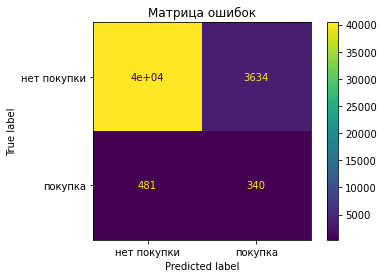

              precision    recall  f1-score   support

 нет покупки       0.99      0.92      0.95     44040
     покупка       0.09      0.41      0.14       821

    accuracy                           0.91     44861
   macro avg       0.54      0.67      0.55     44861
weighted avg       0.97      0.91      0.94     44861


 
Значение порога:  0.979


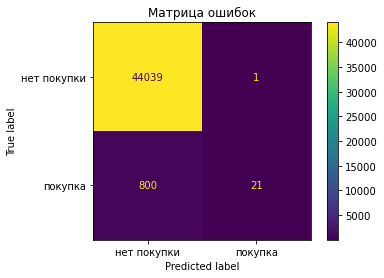

              precision    recall  f1-score   support

 нет покупки       0.98      1.00      0.99     44040
     покупка       0.95      0.03      0.05       821

    accuracy                           0.98     44861
   macro avg       0.97      0.51      0.52     44861
weighted avg       0.98      0.98      0.97     44861


 
Значение порога:  0.983


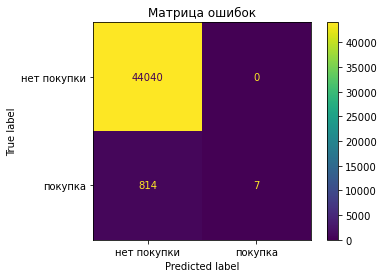

              precision    recall  f1-score   support

 нет покупки       0.98      1.00      0.99     44040
     покупка       1.00      0.01      0.02       821

    accuracy                           0.98     44861
   macro avg       0.99      0.50      0.50     44861
weighted avg       0.98      0.98      0.97     44861


 
Значение порога:  0.009


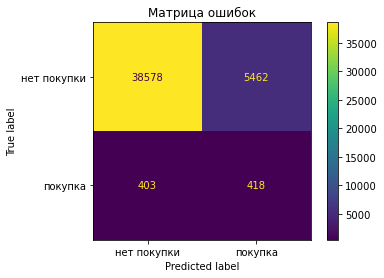

              precision    recall  f1-score   support

 нет покупки       0.99      0.88      0.93     44040
     покупка       0.07      0.51      0.12       821

    accuracy                           0.87     44861
   macro avg       0.53      0.69      0.53     44861
weighted avg       0.97      0.87      0.91     44861


 
Значение порога:  0.007


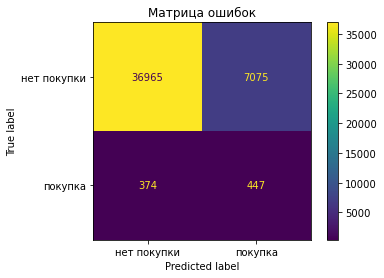

              precision    recall  f1-score   support

 нет покупки       0.99      0.84      0.91     44040
     покупка       0.06      0.54      0.11       821

    accuracy                           0.83     44861
   macro avg       0.52      0.69      0.51     44861
weighted avg       0.97      0.83      0.89     44861



In [78]:
for thresh in [ 0.5, 0.979, 0.983, 0.009, 0.007]:
    cb_search.best_estimator_[-1].set_probability_threshold(thresh)

    cb_predictions_test = cb_search.best_estimator_.predict(
    features_test)

    cm = confusion_matrix(target_test, cb_predictions_test,
                      labels=cb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['нет покупки','покупка']) 
    disp.plot()
    plt.title('Матрица ошибок')
    
    print('\n\033[1m \nЗначение порога: \033[0m', thresh)
    plt.show()
    print(classification_report(target_test,
                        cb_predictions_test, target_names = ['нет покупки','покупка']))

- **Для целей практического использования предлагается использовать модель с порогом чувствительности 0.007, которая дает наибольшее абсолютное количество и долю правильно предсказанных клиентов, из клиентов, которые совершили покупку в течение исследуемых 30 дней, при незначительном (в процентном отношении) увеличении доли клиентов, которые не совершили покупку, но были предсказаны, как совершившие**



- модель правильно предсказала **447** клиентов, которые совершили покупку в исследуемом периоде, и пропустила **374** таких клиента
- модель правильно определила **37 тысяч** клиентов, как не совершивших покупку в исследуемом периоде, и неверно предсказала **7 тысяч** таких клиентов, как совершивших покупку

- безошибочность прогнозирования `accuracy` на тестовой выборке составляет **83%**
- при этом точность предсказания `precision` покупателей, которые **совершили** покупку в тестовом периоде 30 дней составляет **6%** при правильном предсказании `recall` **54%** значений положительного класса тестовой выборки
- точность предсказания `precision` покупателей, которые **не совершили** покупку в тестовом периоде 30 дней составляет **99%** при правильном предсказании `recall` **84%** значений нулевого класса тестовой выборки

### Выводы по результатам тестирования модели `CatBoostClassifier`

- модель `CatBoostClassifier` на **тестовой** выборке показала значение метрики **ROC_AUC = 0.75**, что заметно хуже значения, полученного в ходе кросс-валидации (**0.96**), и связано с **сильным дисбалансом** в тестовой выборке - доля положительных значений целевого признака составляет всего 2%

- метрика `F1-macro` модели `CatBoostClassifier` со стандартным порогом чувствительности = 0.5 на **5** процентных пунктов лучше метрики фиктивной модели, которая всегда предсказывает наиболее частый класс
- выбранная модель **адекватна**

- **Для целей практического использования предлагается использовать модель с порогом чувствительности 0.007, которая дает наибольшее абсолютное количество и долю правильно предсказанных клиентов, из клиентов, которые совершили покупку в течение исследуемых 30 дней, при незначительном (в процентном отношении) увеличении доли клиентов, которые не совершили покупку, но были предсказаны, как совершившие**



- модель правильно предсказала **447** клиентов, которые совершили покупку в исследуемом периоде, и пропустила **374** таких клиента
- модель правильно определила **37 тысяч** клиентов, как не совершивших покупку в исследуемом периоде, и неверно предсказала **7 тысяч** таких клиентов, как совершивших покупку

- безошибочность прогнозирования `accuracy` на тестовой выборке составляет **83%**
- при этом точность предсказания `precision` покупателей, которые **совершили** покупку в тестовом периоде 30 дней составляет **6%** при правильном предсказании `recall` **54%** значений положительного класса тестовой выборки
- точность предсказания `precision` покупателей, которые **не совершили** покупку в тестовом периоде 30 дней составляет **99%** при правильном предсказании `recall` **84%** значений нулевого класса тестовой выборки

- время **обучения и предсказания** модели составляет менее секунды, модель **подходит** для прогнозирования в **реальном времени**

- модель `CatBoostClassifier` с гиперпараметрами:
    - `depth`: 6
    - `iterations`: 9
    - `auto_class_weights` = 'Balanced',
    - и порогом чувствительности: 0.007


    **предлагается к использованию** для прогнозирования клиентов, которые совершат покупку в течение **30** дней

## Отчет

### Описание задачи

- Имеется информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков. В них есть обезличенная история покупок клиентов за определенный период

**Задача:**
- Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

### Предварительная обработка данных

- из датасета `apparel` **удалены** столбцы `recommended_by` и `message_id`
- из датасета `apparel` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

- из датасета `marketplace` **удалены** столбцы `created_at` и `message_id`
- из датасета `marketplace` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

- из датасета `gifts` **удалены** столбцы `recommended_by` и `message_id`
- из датасета `gifts` **удалены** полные дубликаты
- столбец `date` приведен к типу `datetime`

- из трех датасетов `apparel`, `marketplace`, `gifts` создан единый датасет `data`, который будет использован для создания **обучающей** и **тестовой** выборок, **синтетических** признаков и **целевого** признака

- в датасете `data_train` произведено **объединение** всех покупок каждого клиента за один день с указанием суммарной стоимости и удаление ненужных столбцов

### Конструирование признаков

#### Порядок создания признаков и целевого признака таков:
- отрежем от выборки последние 30 дней для создания тестовой выборки, оставшееся - обучающая выборка
---
- посчитаем по всем клиентам обучающей выборки разницу в днях между покупками
- по всем покупкам, срок до предыдущей у которых не более 30 дней, проставим значение целевого признака = 1
- по всем остальным покупкам проставим значение целевого признака = 0
- сделаем базу уникальных клиентов на обучающей выборке
- посчитаем для каждого клиента его характеристики (количество покупок, среднее время между покупками и средний чек)
- присоединим характеристики клиентов из справочника к обучающей выборке
---

- всем строкам в тестовой выборке присвоим значение target = 1, потому что это была покупка
- подсоединим к тестовой выборке характеристики клиентов из созданного на обучающей выборке справочника клиентов с присоединением `right`, чтобы удалить клиентов, совершивших покупку в последний месяц, но отсутствующих в справочнике, так как у нас нет данных для прогнозирования по ним, и добавить всех клиентов, которые есть в справочнике
- всем клиентам в тестовой выборке, у которых целевой признак не равен 1, проставим значение 0, так как они не совершили покупку в последний месяц

- из датасета `data_train` создан **массив признаков** обучающей выборки, имеющий три признака: 
    - средняя дата до предыдущей покупки `days_to_previous_mean`
    - средняя цена всех покупок `price_mean`
    - количество покупок `price_count`
    
    и вектор **целевого** признака `target` 
- размер **обучающей** выборки **54 256** объектов

Использование **других признаков**, таких как минимальная и максимальная длительность периода между покупками, медианные значения цены покупки и длительности между покупками, максимальная и минимальная цена покупки **не дали улучшения** качества модели

### Исследовательский анализ данных

- имеется **сильный** дисбаланс классов: у **целевого** признака **90%** выборки имеет **нулевой** класс, и всего **10%** положительных значений, что необходимо учесть при обучении моделей

- **Анализ распределения количественных признаков в зависимости от значения целевого признака показывает следующее:**

   - более 75% клиентов, не имеющих повторных покупок в течение 30 дней, имеют бесконечно большой средний срок до предыдущей покупки (означает, что предыдущей покупки не было в обозримом периоде)
   - 75% клиентов, у которых были повторные покупки в течение 30 дней, имеют средний срок до предыдущей покупки не более 25.5 дней
   
   - 75% клиентов, не имеющих повторных покупок, имеют общее количество покупок не более 1
   - все клиенты, имеющие повторные покупки, имеют общее количество покупок более 1
   
   - 75% клиентов, не имеющих повторных покупок, имеют средний чек менее 14100 рублей, и половина - менее 3000
   - 50% клиентов, имеющих повторные покупки, имеют средний чек более 12600 рублей
   
- Таким образом, **портрет клиента**, который с большой вероятностью совершит повторную покупку в течение 30 дней:
    - средний срок до предыдущей покупки менее 25 дней
    - имеет более 1 покупки
    - имеет средний чек более 12600 рублей

- имеется **средняя** корреляция целевого признака с `price_count` и `days_to_previous_mean`
- корреляция с признаком средней цены `price_mean` **отсутствует**
- **мультиколлинеарность** между признаками слабая

- синтезированные признаки хорошо подходят для обучения модели и прогнозирования клиентов, которые совершат покупку в течение 30 дней

### Обучение моделей и сравнение метрик

**Были обучены и проверены методом кросс-валидации две модели: `SGDClassifier` и `CatBoostClassifier`**:

- в результате подбора гиперпараметров, обучения и кросс-валидации модели `CatBoostClassifier` было получено значение метрики **AUC_ROC = 0.9617**, что превосходит метрику модели `SGDClassifier` (**0.9597**)
- модель `CatBoostClassifier` с гиперпараметрами:
    - `depth`: 6
    - `iterations`: 9
    - `auto_class_weights` = 'Balanced',


    может быть **рекомендована** для дальнейшего тестирования

### Анализ важности признаков

- анализ важности признаков демонстрирует, что **наиболее значимый** признак - это признак среднего срока до предыдущей покупки `days_to_previous_mean`, на **втором** месте идет признак частоты покупок `price_count`, на третьем, с очень малым весом - средний чек покупателя `price_mean`

### Тестирование модели `CatBoostClassifier`

#### Для проведения тестирования была создана тестовая выборка

- в датасете `data_test` произведено **объединение** всех покупок каждого клиента за один день с указанием суммарной стоимости и удаление ненужных столбцов

- из датасета `data_test` созданы **массив признаков** имеющий три признака: 
    - средняя дата до предыдущей покупки
    - средняя цена всех покупок
    - количество покупок
    
- и вектор **целевого** признака `target_test`

- размер **тестовой** выборки **44861** объекта и **3** признака

#### Проведено обучение модели на обучающей выборке и получены предсказания и их вероятности для тестовой выборки:

- модель `CatBoostClassifier` на **тестовой** выборке показала значение метрики **ROC_AUC = 0.75**, что заметно хуже значения, полученного в ходе кросс-валидации (**0.96**), и связано с **сильным дисбалансом** в тестовой выборке - доля положительных значений целевого признака составляет всего 2%

- метрика `F1-macro` модели `CatBoostClassifier` со стандартным порогом чувствительности = 0.5 на **5** процентных пунктов лучше метрики фиктивной модели, которая всегда предсказывает наиболее частый класс
- выбранная модель **адекватна**

#### Было проведено исследование матрицы ошибок и значений безошибочности, точности и охвата для каждого класса в зависимости от порога чувствительности

- **Для целей практического использования предлагается использовать модель с порогом чувствительности 0.007, которая дает наибольшее абсолютное количество и долю правильно предсказанных клиентов, из клиентов, которые совершили покупку в течение исследуемых 30 дней, при незначительном (в процентном отношении) увеличении доли клиентов, которые не совершили покупку, но были предсказаны, как совершившие**



- модель правильно предсказала **447** клиентов, которые совершили покупку в исследуемом периоде, и пропустила **374** таких клиента
- модель правильно определила **37 тысяч** клиентов, как не совершивших покупку в исследуемом периоде, и неверно предсказала **7 тысяч** таких клиентов, как совершивших покупку

- безошибочность прогнозирования `accuracy` на тестовой выборке составляет **83%**
- при этом точность предсказания `precision` покупателей, которые **совершили** покупку в тестовом периоде 30 дней составляет **6%** при правильном предсказании `recall` **54%** значений положительного класса тестовой выборки
- точность предсказания `precision` покупателей, которые **не совершили** покупку в тестовом периоде 30 дней составляет **99%** при правильном предсказании `recall` **84%** значений нулевого класса тестовой выборки

- время **обучения и предсказания** модели составляет менее секунды, модель **подходит** для прогнозирования в **реальном времени**

## Заключение

- модель `CatBoostClassifier` с гиперпараметрами:
    - `depth`: 6
    - `iterations`: 9
    - `auto_class_weights` = 'Balanced',
    - и порогом чувствительности: 0.007


    **предлагается к использованию** для прогнозирования клиентов, которые совершат покупку в течение **30** дней